# Agenda
Spectral clustering of GPs' bitmaps.



In [21]:
# Installing Libraries (if not installed)
#!pip3 install jupyterlab-git
#!pip3 install matplotlib
#!pip3 install scikit-learn
#!pip3 install seaborn
#!pip3 install numpy
#!pip3 install pandas
#!pip3 install so4gp
#!pip3 install scipy
#!pip3 install sympy

# Import libraries <a name="lib-import"></a>

In [2]:
# Importing Libraries
import pandas as pd
import numpy as np
from numpy.linalg import svd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import sympy
import scipy


from scipy.sparse import csgraph, csr_matrix
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import KMeans
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics import homogeneity_score, completeness_score,v_measure_score
from numpy import linalg as la

In [3]:
import so4gp as sgp

# Spectral Clustering

Adopted from: [Towards data science](https://towardsdatascience.com/graph-laplacian-and-its-application-in-machine-learning-7d9aab021d16)

## Data set
Data set is the GP bitmaps (X0, X1, ..., Xn). Each attribute generates a GP bitmap.

In [26]:
#from sklearn.datasets import make_moons
#features, y = make_moons(n_samples=10, noise=0.07, random_state=213)
#features
#y, features

In [46]:

ds = sgp.DataGP('data\DATASET.csv')
data_size = ds.row_count
features = np.array(ds.data, dtype=np.float64)
features

array([[30.,  3.,  1., 10.,  2.,  4.],
       [35.,  2.,  2.,  8.,  2.,  4.],
       [40.,  4.,  2.,  7.,  2.,  4.],
       [50.,  1.,  1.,  6.,  2.,  4.],
       [52.,  7.,  1.,  2.,  2.,  4.]])

In [47]:
bm_matrix = []
for i in ds.attr_cols:
    bm = sgp.gibitmap(ds, i)
    bm_matrix.append(bm)
    
bm_matrix = np.array(bm_matrix, dtype=int)

In [48]:
#gp_map = so.get_bin_arr(ds, 0)
X0 = sgp.gibitmap(ds, 0)
X1 = sgp.gibitmap(ds, 1)
X2 = sgp.gibitmap(ds, 2)
X3 = sgp.gibitmap(ds, 3)
X2

array([[0, 0, 0, 0, 0],
       [1, 0, 0, 1, 1],
       [1, 0, 0, 1, 1],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])

## Constructing K-nearest neighbors graph
Based on connectivity (0 or 1)

In [106]:
# Constructing K-nearest neighbors graph
X = features[:, 0:2] #X2
n_neighbors = 4
knn_dist_graph = kneighbors_graph(X=X,
                                 n_neighbors=n_neighbors,
                                 #mode='distance')
                                 mode='connectivity')
print(X)
print("\n")
knn_dist_graph.todense()#[0][:,:50]

[[30.  3.]
 [35.  2.]
 [40.  4.]
 [50.  1.]
 [52.  7.]]




matrix([[0., 1., 1., 1., 1.],
        [1., 0., 1., 1., 1.],
        [1., 1., 0., 1., 1.],
        [1., 1., 1., 0., 1.],
        [1., 1., 1., 1., 0.]])

## Computing Similarity


In [87]:
# Similarity graph

sigma = 1
similarity_graph = csr_matrix(knn_dist_graph.shape)
nonzeroindices = knn_dist_graph.nonzero()
similarity_graph[nonzeroindices] = np.exp( -np.asarray(knn_dist_graph[nonzeroindices])**2 / 2.0 * sigma**2)
similarity_graph = 0.5 * (similarity_graph + similarity_graph.T)
similarity_graph.todense()#[0][:,:5]

C:\Users\dowuor\AppData\Local\Programs\Python\Python37\lib\site-packages\scipy\sparse\_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


matrix([[0.00000000e+000, 2.26032941e-006, 1.16984592e-022,
         1.87290028e-088, 2.66919022e-109],
        [2.26032941e-006, 0.00000000e+000, 5.04347663e-007,
         8.40859712e-050, 6.54284062e-069],
        [1.16984592e-022, 5.04347663e-007, 0.00000000e+000,
         2.14264754e-024, 5.97684694e-034],
        [1.87290028e-088, 8.40859712e-050, 2.14264754e-024,
         0.00000000e+000, 2.06115362e-009],
        [2.66919022e-109, 6.54284062e-069, 5.97684694e-034,
         2.06115362e-009, 0.00000000e+000]])

## Deriving Graph Laplacian representation
L = D-W

D: Degree matrix

W: Similarity graph

In [88]:
# Degree Matrix

W = similarity_graph
D = W.sum(axis=1)
D = np.diag(np.asarray(D).reshape(data_size,))
D

array([[2.26032941e-06, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [0.00000000e+00, 2.76467707e-06, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 5.04347663e-07, 0.00000000e+00,
        0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.06115362e-09,
        0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        2.06115362e-09]])

In [89]:
# Laplacian Matrix
L = D - W
L

matrix([[ 2.26032941e-006, -2.26032941e-006, -1.16984592e-022,
         -1.87290028e-088, -2.66919022e-109],
        [-2.26032941e-006,  2.76467707e-006, -5.04347663e-007,
         -8.40859712e-050, -6.54284062e-069],
        [-1.16984592e-022, -5.04347663e-007,  5.04347663e-007,
         -2.14264754e-024, -5.97684694e-034],
        [-1.87290028e-088, -8.40859712e-050, -2.14264754e-024,
          2.06115362e-009, -2.06115362e-009],
        [-2.66919022e-109, -6.54284062e-069, -5.97684694e-034,
         -2.06115362e-009,  2.06115362e-009]])

In [90]:
# Laplacian Matrix

L = csgraph.laplacian(W, normed=False)
L.toarray()

array([[ 2.26032941e-006, -2.26032941e-006, -1.16984592e-022,
        -1.87290028e-088, -2.66919022e-109],
       [-2.26032941e-006,  2.76467707e-006, -5.04347663e-007,
        -8.40859712e-050, -6.54284062e-069],
       [-1.16984592e-022, -5.04347663e-007,  5.04347663e-007,
        -2.14264754e-024, -5.97684694e-034],
       [-1.87290028e-088, -8.40859712e-050, -2.14264754e-024,
         2.06115362e-009, -2.06115362e-009],
       [-2.66919022e-109, -6.54284062e-069, -5.97684694e-034,
        -2.06115362e-009,  2.06115362e-009]])

In [91]:
# Normalized Laplacian Matirx: 

L_norm = csgraph.laplacian(W, normed=True)
L_norm.toarray()

array([[ 1.00000000e+000, -9.04198250e-001, -1.09566500e-016,
        -2.74393366e-081, -3.91055570e-102],
       [-9.04198250e-001,  1.00000000e+000, -4.27113011e-001,
        -1.11389988e-042, -8.66740230e-062],
       [-1.09566500e-016, -4.27113011e-001,  1.00000000e+000,
        -6.64554417e-017, -1.85375334e-026],
       [-2.74393366e-081, -1.11389988e-042, -6.64554417e-017,
         1.00000000e+000, -1.00000000e+000],
       [-3.91055570e-102, -8.66740230e-062, -1.85375334e-026,
        -1.00000000e+000,  1.00000000e+000]])

## Computing eigenvalues

In [118]:
# Finding eigen values and eigen vectors
e, evecs = la.eig(L_norm.todense())
e, evecs

(array([0.0000000e+00, 2.0000000e+00, 1.0000000e+00, 4.4408921e-16,
        2.0000000e+00]),
 matrix([[ 6.39364714e-01,  6.39364714e-01,  4.27113011e-01,
          -2.04220880e-02, -8.17233779e-03],
         [ 7.07106781e-01, -7.07106781e-01, -2.11962307e-17,
          -2.25858521e-02,  9.03821455e-03],
         [ 3.02014506e-01,  3.02014506e-01, -9.04198250e-01,
          -9.64671129e-03, -3.86033903e-03],
         [ 5.69416017e-33,  5.69416017e-33, -1.70476900e-32,
           7.06745979e-01,  7.07049016e-01],
         [ 1.58836781e-42,  1.58836781e-42, -4.75539872e-42,
           7.06745979e-01, -7.07049016e-01]]))

In [93]:
# No. of eigen values equal to 0
e_rounded_off = e.round(5)
e_rounded_off[e_rounded_off == 0].shape
e_rounded_off

array([0., 2., 1., 0., 2.])

In [94]:
# No. of connected components
#nx.number_connected_components(nx_graph)

## Partitioning data points

In [95]:
sorted_idxs = np.argsort(e_rounded_off)
sorted_idxs

array([0, 3, 2, 1, 4], dtype=int64)

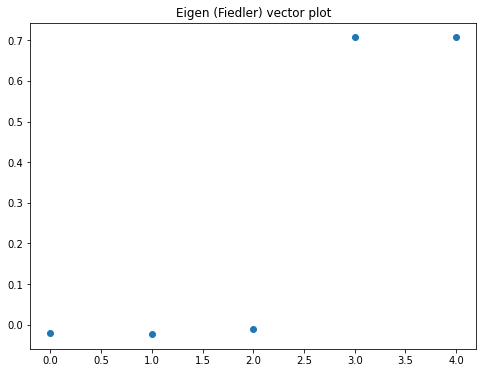

In [96]:
# Using Fiedler vector (Obtained from eigenvalue)

# Get smallest non-zero eigen value's index for obtaining partition to cluster
fiedler_index = sorted_idxs[1]

# The eigen vector for smallest non-zero eigen value i.e plotting the Fiedler vector
plt.figure(figsize=(8,6))
plt.scatter(np.arange(data_size), evecs[:,fiedler_index].tolist())
plt.title("Eigen (Fiedler) vector plot")
plt.show()




[[-0.02042209]
 [-0.02258585]
 [-0.00964671]
 [ 0.70674598]
 [ 0.70674598]]
[0. 0. 0. 1. 1.]


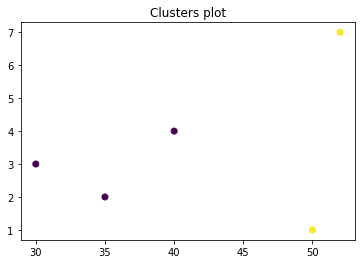

In [121]:
fiedler_vector = evecs[:,fiedler_index].copy()
print(fiedler_vector)

# Thresholding the values in this eigen vector at 0
fiedler_vector[fiedler_vector < 0.0] = 0
fiedler_vector[fiedler_vector > 0.0] = 1
new_labels = np.asarray(fiedler_vector)[:,0]
print(new_labels)

# Plot cluster result
plt.scatter(X[:,0], X[:,1], c=new_labels.astype(float))
plt.title("Clusters plot")
plt.show()

[1 0 1 1 0]


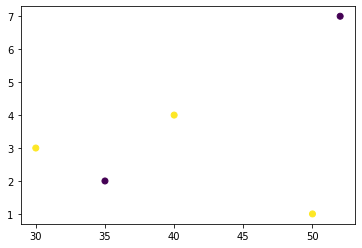

In [98]:
# Using KMeans clustering (NOT VERY  ACCURATE)
num_clusters = 2
kmean_labels = KMeans(n_clusters=num_clusters).fit_predict(L_norm)
print(kmean_labels)

plt.scatter(X[:,0], X[:,1], c=kmean_labels.astype(float))
plt.show()

In [99]:
# Evaluation of clustering result of KMeans (true_labels, predicted_labels)
y = kmean_labels 
homogeneity_score(y, new_labels), completeness_score(y, new_labels), v_measure_score(y, new_labels)

(0.020570659450692717, 0.020570659450692717, 0.020570659450692717)

In [67]:
# Check if cluster_centers of different bitmaps can be used to compute support (AND operation)